# New pattern generation algorithm

In [1]:
%pylab inline
#nice plotting
#import seaborn as sns
import numexpr as ne
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image
import os
import zipfile
import numexpr as ne

Populating the interactive namespace from numpy and matplotlib


In [2]:
#original algorithm from mathematica
def patterntabArbOld(vecA, period, onfrac = 0.5, phaseInd = 0, phaseOffset = 0., nphases =5, sizex =2048, sizey =1536):
    veckA = array([[0,1],[-1,0]]).dot(vecA)
    vecB = veckA/norm(vecA)*period
    area = vecB.dot(veckA)
    onpix = area*onfrac
    phaseStep = vecB/nphases
    
    toReturn = zeros((sizex,sizey))
    
    val = (phaseStep*phaseInd+phaseOffset/(2*pi)*vecB)
    
    #return array([[mod((array([i,j])-val).dot(veckA),area) < onpix for i in range(1,sizex)] for j in range(1,sizey)])
    
    for i in range(sizex):
        for j in range(sizey):
            if mod((array([i,j])-val).dot(veckA),area) < onpix:
                toReturn[i,j] = 1
            else:
                toReturn[i,j] = 0
            
    return toReturn.T

In [3]:
#faster working one
def pattern_gen_old(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    area = vecB.dot(vecN)
    onpix = area*onfrac
    phase_step = vecB/nphases
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step/=2
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB)
    
    xx, yy = meshgrid(arange(sizex,dtype=float32),arange(sizey,dtype=float32))
    my_grid = dstack((xx,yy))
    my_grid -= val
    
    mydot = my_grid.dot(vecN)
    return mod(mydot,area) < onpix

In [35]:
#newest one
def pattern_gen_new(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    #turns out that area doesn't matter (it drops out in the mod operation) so therefore the magnitude of a
    #also doesn't matter. We should change this function to simply take an angle from which it can generate the
    #bvector. The bvector has a length of period and an angle that is -90 degrees relative to the given angle
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    phase_step = vecB/nphases
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step/=2
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB).reshape(2,1,1)
    
    #xx, yy = meshgrid(arange(sizex,dtype=float32),arange(sizey,dtype=float32))
    #my_grid = dstack((xx,yy))
    #my_grid -= val
    
    my_grid = indices((sizey,sizex),dtype=float)-val
    
    #Need to reshape to matrix because of BLAS 
    #(http://stackoverflow.com/questions/11856293/numpy-dot-product-very-slow-using-ints)
    mydot = (my_grid.reshape(2,sizey*sizex).T).dot(vecB).reshape(sizey, sizex)
    
    toreturn = mydot-mydot.astype(int)
    #fix the phase problem
    toreturn[toreturn < 0]+=1

    return toreturn < onfrac

In [182]:
#newest one
def pattern_gen_new2(angle, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    Generates a sine wave and then binarizes it
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step = 2
    else:
        phase_step = 1
    
    #indices are backwards here for backwards compatability with older generation code.
    xx, yy = meshgrid(arange(sizex,dtype=float32),arange(sizey,dtype=float32))
    
    #here's the pattern frequency
    freq = 2*pi/period
    
    #here's the phase stepping, note that its in the negative direction for backwards compatibility.
    phi = -(phase_idx/nphases/phase_step)*(2*pi)+phase_offset
    
    #our sine goes from -1 to 1 while on frac goes from 0,1 so move onfrac into the right range
    onfrac = onfrac*2-1
    
    #again, angle is negative to comply with previous versions
    angle*=-1
    
    #do the evaluation
    toreturn = ne.evaluate("sin(freq*(cos(angle)*xx+sin(angle)*yy)+phi) > onfrac")
    
    return toreturn

In [ ]:
%timeit -r1 -n1 zz = patterntabArbOld([1,12],7,sizey=2048)
%timeit -r1 -n1 zz = pattern_gen_old([1,12],7,sizey=2048)

In [177]:
%timeit -r1 -n1 zz = pattern_gen_new([1,12],7,sizey=2048)

1 loops, best of 1: 152 ms per loop


In [194]:
%timeit -r1 -n1 zz = pattern_gen_new2(deg2rad(4.76),7,sizey=2048)

1 loops, best of 1: 63.9 ms per loop


In [52]:
%prun zz = pattern_gen_new2(deg2rad(4.76),7,sizey=2048)

In [65]:
original = patterntabArbOld([1,12],7,sizey=2048)

In [66]:
working = pattern_gen_old([1,12],7,sizey=2048)

In [67]:
(original == working).all()

True

In [141]:
original = patterntabArbOld([1,12],7,sizex=2048,sizey=2048)

In [142]:
working = pattern_gen_old([1,12],7,sizex = 2048, sizey=2048)

In [143]:
(original == working).all()

True

In [144]:
rad2deg(arctan2(12,-1)-pi/2)

4.7636416907261916

In [145]:
newest = pattern_gen_new2(arctan2(12,-1)-pi/2,7,sizex = 2048,sizey=2048)

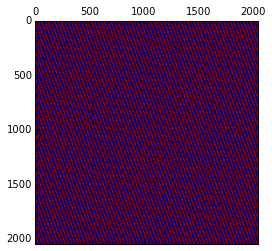

In [146]:
matshow(original)

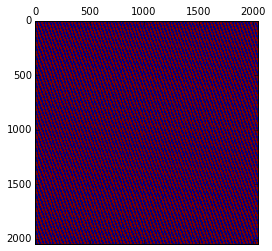

In [147]:
matshow(newest)

In [156]:
(newest == working).all()

False

In [155]:
(working-newest).sum()/product(newest.shape)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
  if __name__ == '__main__':


4.0769577026367188e-05

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
  from ipykernel import kernelapp as app


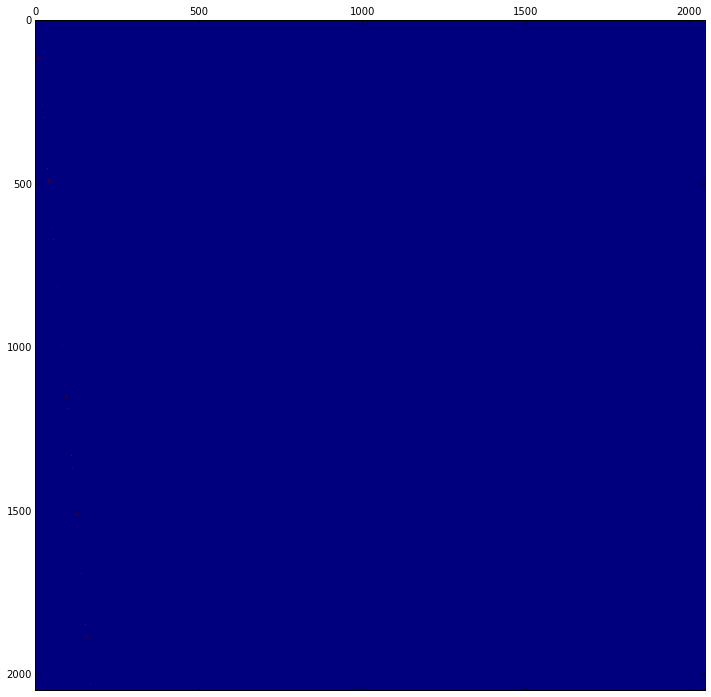

In [158]:
fig,ax = subplots(1,1,figsize=(12,12))
ax.matshow(working-newest)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: numpy boolean subtract (the binary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


4.06901041667e-05
0.0
0.0
0.0
0.0


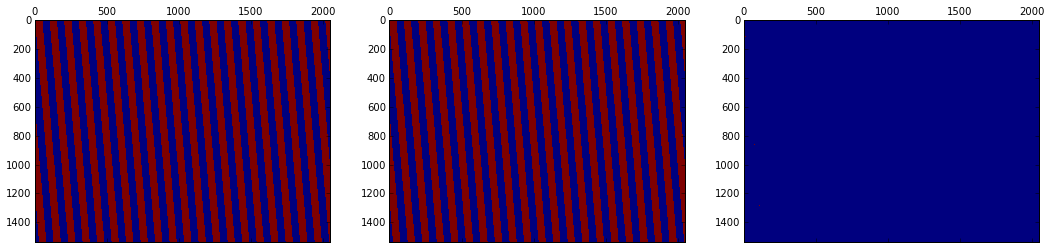

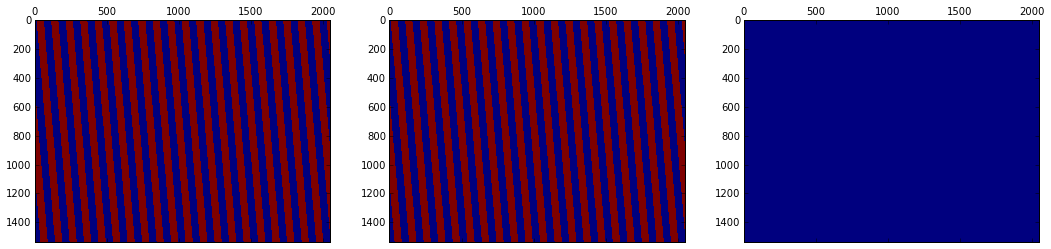

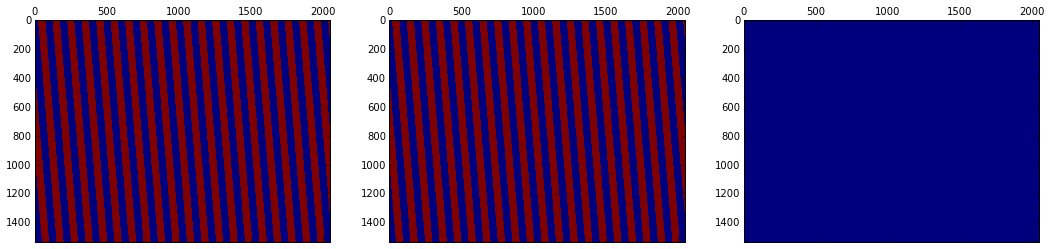

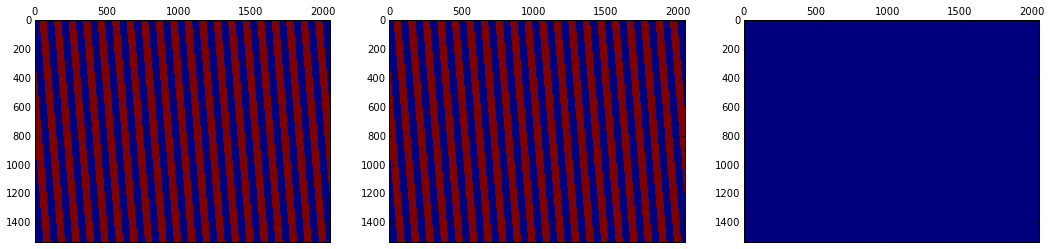

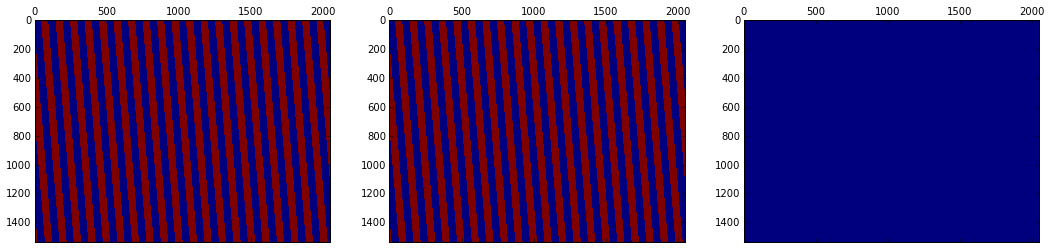

In [192]:
for i in range(5):
    working = pattern_gen_old([1,12],100,phase_idx=i)
    newest = pattern_gen_new2(arctan2(12,-1)-pi/2,100,phase_idx=i)
    the_diff = (working-newest).sum()/product(newest.shape)
    print(the_diff)
    fig,ax = subplots(1,3,figsize=(18,6))
    ax[0].matshow(working)
    ax[1].matshow(newest)
    ax[2].matshow(newest-working)

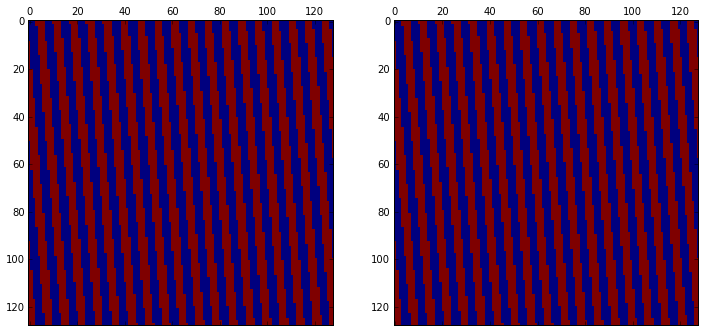

In [173]:
fig,ax = subplots(1,2,figsize=(12,6))
ax[0].matshow(working)
ax[1].matshow(newest)